# Pansharpening Landsat using `xr_pansharpen` <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `DEA Sandbox` and `NCI` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Background

Panchromatic sharpening ("pansharpening") is an image processing technique used to increase the spatial resolution of an image by combining a higher resolution "panchromatic" band with lower resolution multispectral bands. 
The resulting image has both the higher spatial resolution of the panchromatic band, and the spectral information of the multispectral bands.

Compared to multispectral satellite bands that cover multiple narrow portions of the electromagnetic spectrum, a panchromatic satellite band covers a wide range of spectra that overlaps with multiple multispectral bands.
This wider spectral range allows panchromatic bands to be collected at a higher spatial resolution due to a higher incoming signal-to-noise ratio.

Since Landsat 7, Landsat satellite sensors have included a 15 metre resolution panchromatic band.
Using pansharpening, we can use this band to increase the spatial resolution of Landsat multispectral bands from their usual 30 metre resolution to 15 metre resulution, resulting in higher resolution multispectral data.


## Description
In this example we will load Landsat 8 data, and demonstrate how to improve its spatial resolution from 30 to 15 metres using several common pansharpening transforms implemented using the `xr_pansharpen` function from `dea_tools.data_handling`:

1. [Define our area of interest](#Analysis-parameters)
2. [Load in a single true colour Landsat 8 image](#Loading-data)
3. [Apply the Brovey transform to pansharpen our data](#Apply-Brovey-pansharpening)
4. [Explore and compare multiple pansharpening methods](#Other-pansharpening-methods)
5. [Automatically apply pansharpening to multiple timesteps/images](#Pansharpening-multiple-timesteps/images)
6. [Pansharpen false colour Landsat 7 imagery using the NIR band](#Pansharpening-Landsat-7)
7. [Advanced: Evaluate the performance of pansharpening algorithms](#Advanced)

***

## Getting started

### Load packages
Import Python packages that are used for the analysis.

In [2]:
import datacube
import xarray as xr
import matplotlib.pyplot as plt

import sys

sys.path.insert(1, "../Tools/")
from dea_tools.datahandling import xr_pansharpen, mostcommon_crs, load_ard
from dea_tools.plotting import rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data:

In [3]:
dc = datacube.Datacube(app="Pan_sharpening")

### Analysis parameters

First we define a spatio-temporal Datacube query to load data over Parliament House in Canberra for a specific date:


In [69]:
# Parliament House, Canberra
query = {
    "x": (149.12, 149.144),
    "y": (-35.312, -35.29),
    "time": ('2020-05-07'),
}

### Determine native resolution
Pansharpening works best if our data is loaded as close as possible to its original pixel size and alignment, with no additional reprojection or resampling.

This section ensures your data is loaded in its 'native projection': the projection the data is stored in on file.
This will ensure maximum fidelity of your data by preventing data from being needlessly re-projected when loaded.

In [70]:
output_crs = mostcommon_crs(dc=dc, query=query, product="ga_ls8c_ard_3")
output_crs

'epsg:32655'

## Loading data
In this example we combine the Brovey Transform, Landsat 8's panchromatic band and multispectral data resampled using bilinear interpolation to pan-sharpen the red, green and blue Landsat bands from 30 x 30 m resolution to 15 x 15 m. 

In the cells below, we load red, green, blue and panchromatic band data at 15 m resolution, resampling the three visual bands using the `resampling` method specified above. 
For comparison, we also load the same three visual bands at their native 30 m resolution to serve as a reference dataset.

In [71]:
# Load red, green, blue and panchromatic band data for our area of
# interest at 15 m resolution
rgbp_15m = load_ard(dc=dc,
    products=["ga_ls8c_ard_3"],
    measurements=["nbart_red", "nbart_green", "nbart_blue", "nbart_panchromatic"],
    resolution=(-15, 15),
    align=(7.5, 7.5),
    output_crs=output_crs,
    resampling="bilinear",
    group_by="solar_day",
    mask_pixel_quality=False,
    **query
)

Finding datasets
    ga_ls8c_ard_3
Loading 1 time steps


In [72]:
# For reference, load the same image at 30 m resolution
rgb_30m = load_ard(dc=dc,
    products=["ga_ls8c_ard_3"],
    measurements=["nbart_red", "nbart_green", "nbart_blue"],
    resolution=(-30, 30),
    align=(15, 15),
    output_crs=output_crs,
    group_by="solar_day",
    mask_pixel_quality=False,
    **query
)

Finding datasets
    ga_ls8c_ard_3
Loading 1 time steps


### Visualise the panchromatic band
To visualise how the spatial resolution of Landsat's panchromatic band compares to the spatial resolution of the red, green and blue bands, we can plot both options. 
In the example below, we plot the 30 m Landsat 8 green band on the left, and the 15 m panchromatic band on the right. 
It should be clear how much additional spatial detail is visible in the panchromatic band.

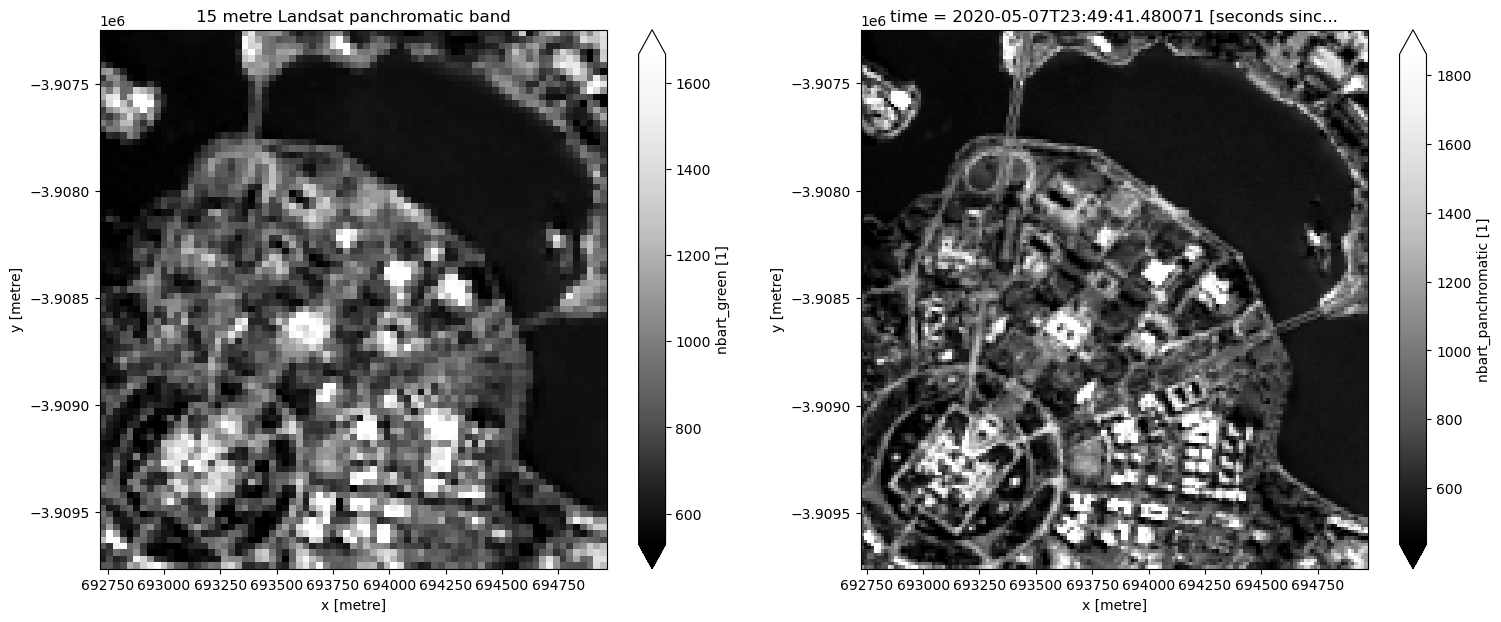

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
rgb_30m.nbart_green.plot(ax=axes[0], cmap="Greys_r", robust=True)
rgbp_15m.nbart_panchromatic.plot(ax=axes[1], cmap="Greys_r", robust=True)
axes[0].set_title("30 metre Landsat green band")
axes[0].set_title("15 metre Landsat panchromatic band");

## Apply Brovey pansharpening
To demonstrate how to apply pansharpening with `xr_pansharpen`, we will first apply a popular pansharpening method called the **Brovey transform**. 

Brovey pansharpening is a simple algorithm designed to optimise visual contrast at both ends of the satellite imagery's histogram.
The approach multiplies each lower resolution multispectral  band by the ratio of the higher resolution panchromatic band, divided by the sum of all three multispectral bands [(source)](https://pro.arcgis.com/en/pro-app/latest/help/analysis/raster-functions/fundamentals-of-pan-sharpening-pro.htm).
Brovey pansharpening is primarily used for visual analysis as it isn't guaranteed to maintain spectral integrity of the input data.

> **Note:** Because Landsat 8 and 9's Blue band only slightly overlaps with the panchromatic band, `xr_pansharpen` applies a weighted sum of the multispectral bands in the Brovey calculation: Red and Green are both weighted 40%, and Blue is weighted 20%. 
This can be overruled using the `band_weights` parameter.

In [74]:
# Perform Brovey pansharpening 
rgb_brovey_15m = xr_pansharpen(rgbp_15m, transform="brovey")


Applying Brovey pansharpening


### Plot and compare pansharpened data to original data

To evaluate our pan-sharpened image, we can compare it with our previously loaded reference data.
In the image below, we plot our original 30 m resolution reference data, the resampled but not pansharpened 15 m resolution input data, and finally our 15 m pansharpened image:

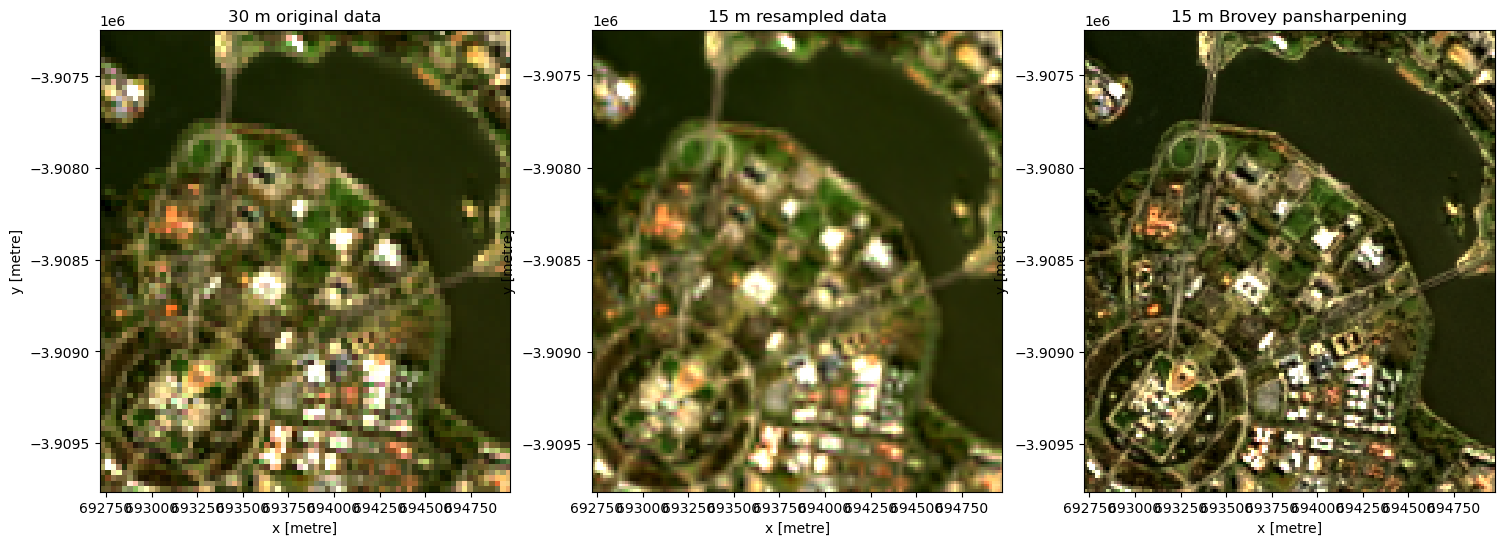

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
rgb(ds=rgb_30m, ax=axes[0])
rgb(ds=rgbp_15m, ax=axes[1])
rgb(ds=rgb_brovey_15m, ax=axes[2])
axes[0].set_title("30 m original data")
axes[1].set_title("15 m resampled data")
axes[2].set_title("15 m Brovey pansharpening");

Looking at the images above, the pansharpened image appears sharp and detailed, while still retaining the multispectral data (i.e. RGB colours) that were not originally included in the panchromatic band.

## Other pansharpening methods

The `xr_pansharpen` function currently supports several other common pansharpening methods, including:

* **Simple mean ("simple mean"):** Takes the average of each low resolution multispectral band and the panchromatic band [(source)](https://pro.arcgis.com/en/pro-app/latest/help/analysis/raster-functions/fundamentals-of-pan-sharpening-pro.htm).
* **ESRI ("esri"):** Takes the mean of the all low resolution multispectral bands, then subtracts this from the higher panchromatic band to produce an "adjustment factor" which is then added back to each band [(source)](https://pro.arcgis.com/en/pro-app/latest/help/analysis/raster-functions/fundamentals-of-pan-sharpening-pro.htm).
* **Hue Saturation Value ("hsv"):** Converts low resolution image data from RGB to HSV colour space, where "V" represents "Value", or the relative lightness or darkness of the image. This band is replaced with the higher resolution panchromatic band, then converted back to the original RGB colour space.
* **Principal Components Analysis ("pca"):** transforms low resolution original data into its principal components, then substitutes the first principal component with the higher resolution panchromatic band.


> **Note:**  Pan-sharpening transforms do not necessarily maintain the spectral integrity of the input satellite data, and may be more suitable for visualisation than quantitative analysis.
We recommend you investigate the performance of all these methods for your specific application before making a selection.


In [76]:
rgb_simplemean_15m = xr_pansharpen(rgbp_15m, transform="simple mean")
rgb_esri_15m = xr_pansharpen(rgbp_15m, transform="esri")
rgb_hsv_15m = xr_pansharpen(rgbp_15m, transform="hsv")
rgb_pca_15m = xr_pansharpen(rgbp_15m, transform="pca")

Applying Simple mean pansharpening
Applying Esri pansharpening
Applying HSV pansharpening to each timestep
Applying PCA pansharpening to each timestep


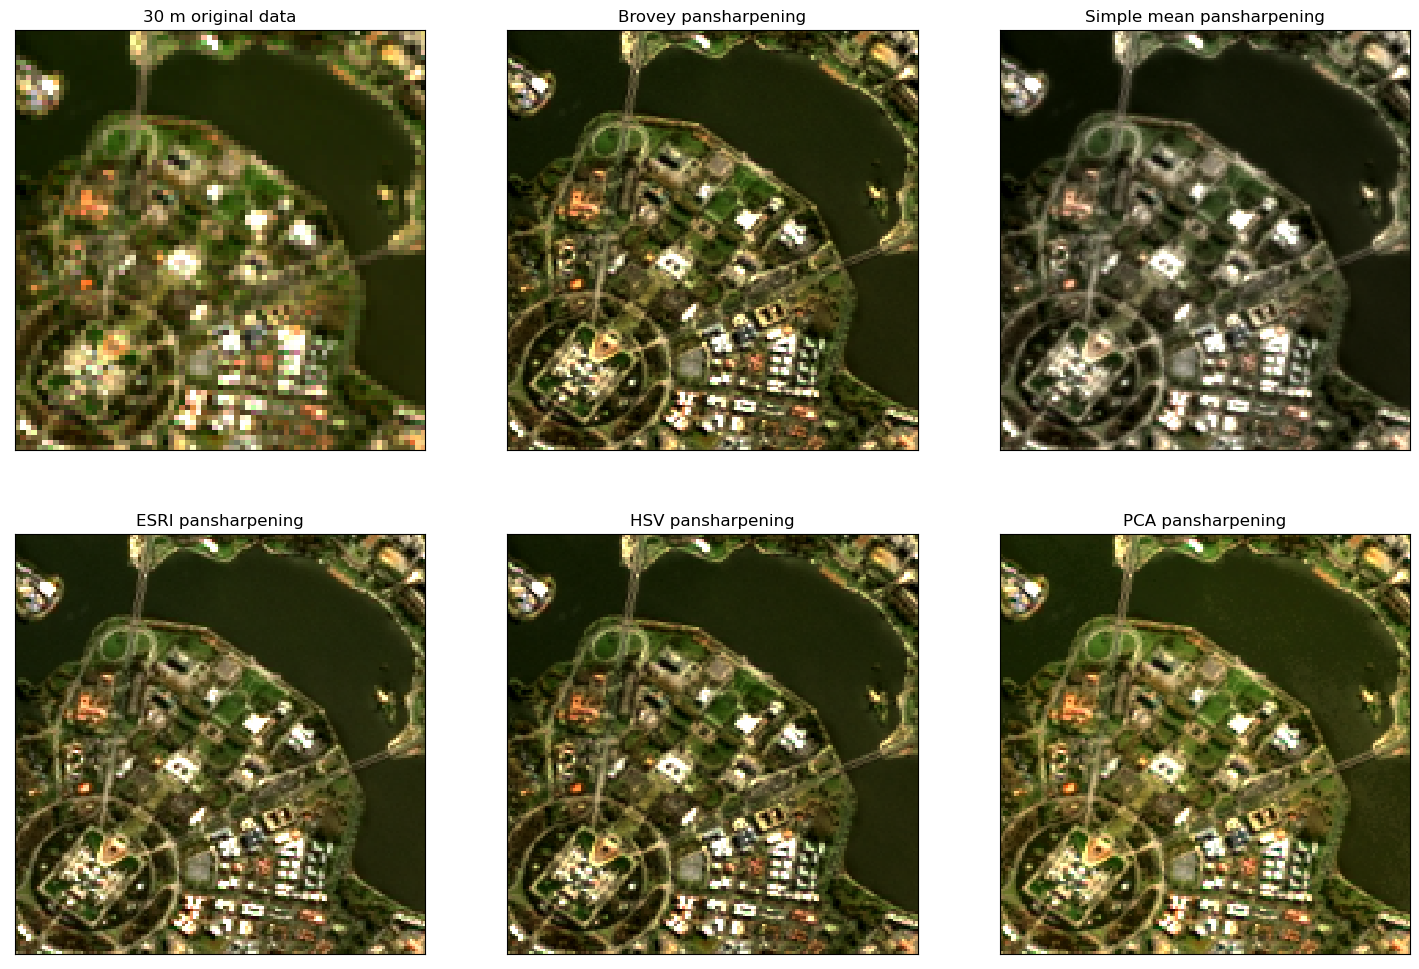

In [77]:
# Create empty 2 x 3 figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot each pansharpening method in RGB
rgb(ds=rgb_30m, ax=axes[0])
rgb(ds=rgb_brovey_15m, ax=axes[1])
rgb(ds=rgb_simplemean_15m, ax=axes[2])
rgb(ds=rgb_esri_15m, ax=axes[3])
rgb(ds=rgb_hsv_15m, ax=axes[4])
rgb(ds=rgb_pca_15m, ax=axes[5])

# Add titles to plots
axes[0].set_title("30 m original data")
axes[1].set_title("Brovey pansharpening")
axes[2].set_title("Simple mean pansharpening")
axes[3].set_title("ESRI pansharpening")
axes[4].set_title("HSV pansharpening")
axes[5].set_title("PCA pansharpening")

# Hide x and y axis labels
for ax in axes:
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

## Pansharpening multiple timesteps/images
The `xr_pansharpen` function can be used to automatically apply pansharpening to every timestep in an `xr.Dataset`. 
For example, we might have a time series containing three timesteps of Landsat 8 imagery like the example below:

Finding datasets
    ga_ls8c_ard_3
Loading 3 time steps
Finding datasets
    ga_ls8c_ard_3
Loading 3 time steps


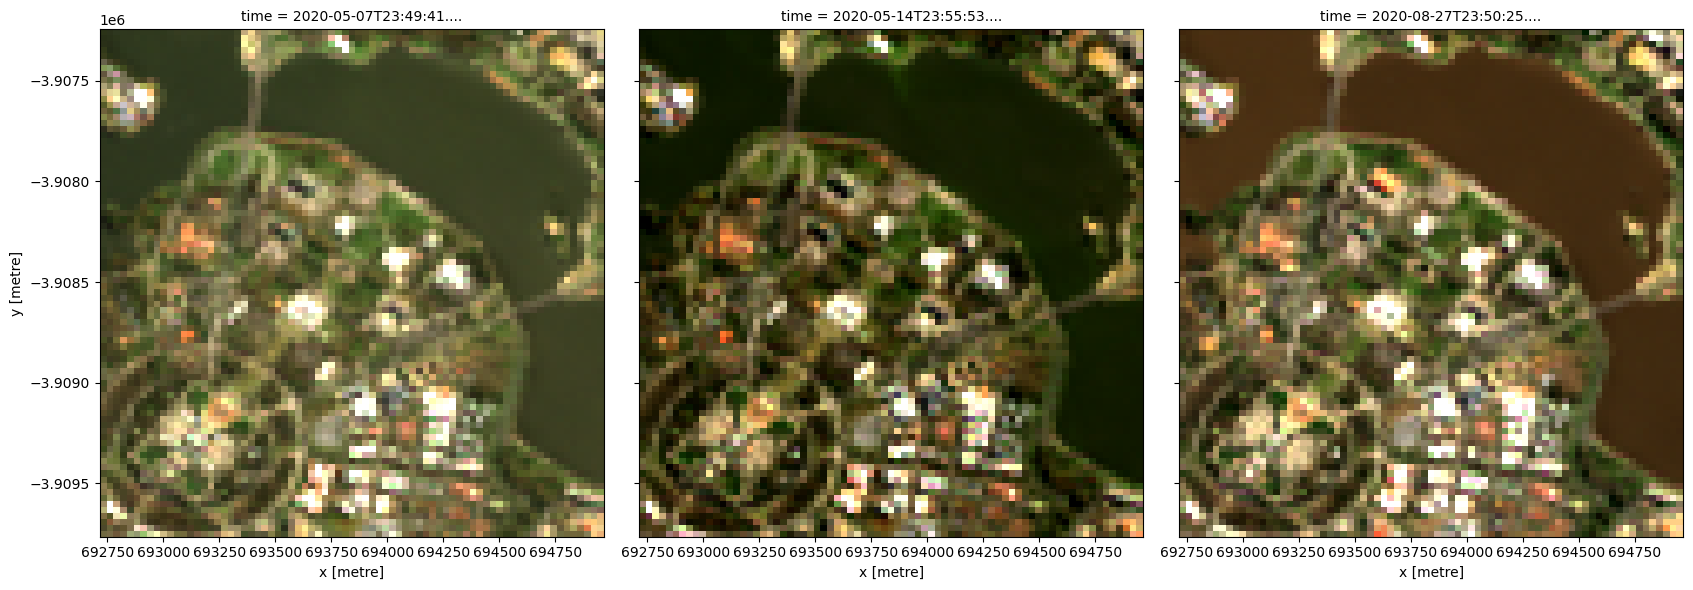

In [78]:
query = {
    "x": (149.12, 149.144),
    "y": (-35.312, -35.29),
    "time": ('2020-05', '2020-08'),
    "cloud_cover": (0, 10)
}

# Load red, green, blue and panchromatic band data at 15 m resolution
rgbp_15m = load_ard(dc=dc,
    products=["ga_ls8c_ard_3"],
    measurements=["nbart_red", "nbart_green", "nbart_blue", "nbart_panchromatic"],
    resolution=(-15, 15),
    align=(7.5, 7.5),
    output_crs=output_crs,
    resampling="bilinear",
    group_by="solar_day",
    mask_pixel_quality=False,
    **query
)

# For reference, load the same image at 30 m resolution
rgb_30m = load_ard(dc=dc,
    products=["ga_ls8c_ard_3"],
    measurements=["nbart_red", "nbart_green", "nbart_blue"],
    resolution=(-30, 30),
    align=(15, 15),
    output_crs=output_crs,
    group_by="solar_day",
    mask_pixel_quality=False,
    **query
)

# Plot our original 30 m true colour images
rgb(rgb_30m, col="time")

To apply pansharpening to each image, simply provide it to the `xr_pansharpen` function in the same way as a dataset with one image: 

Applying PCA pansharpening to each timestep


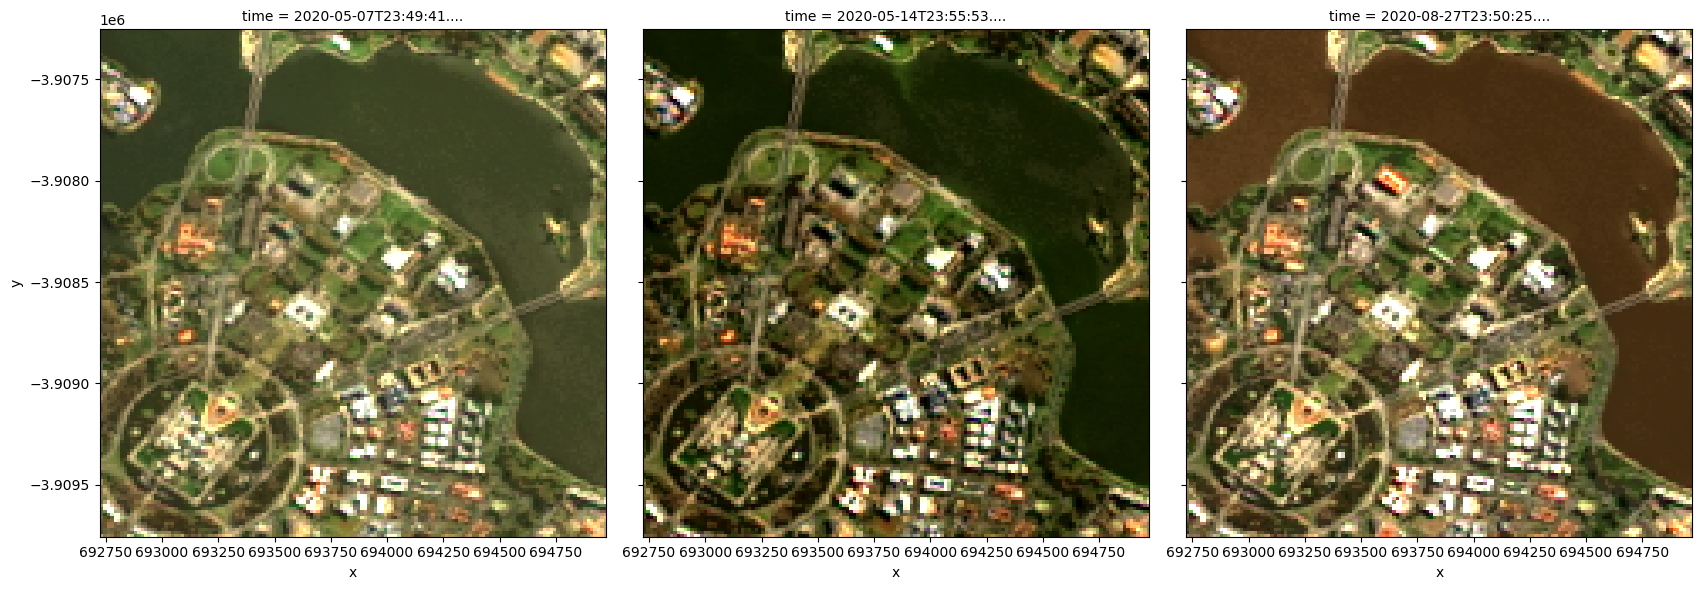

In [79]:
# Perform PCA pansharpening 
rgb_pca_15m = xr_pansharpen(rgbp_15m, transform="pca")

# Plot our pansharpened 15 m true colour images
rgb(rgb_pca_15m, col="time")

## Pansharpening Landsat 7

We can also use `xr_pansharpen` to pansharpen Landsat 7 imagery.
However, it is important to note that the Landsat 7's panchromatic band is different to the Landsat 8 and 9 panchromatic band: instead of overlapping with the Red, Green and Blue multispectral bands, Landsat 7's panchromatic band overlaps with the Near Infrared (NIR, or Landsat 7 Band 4), Red and Green bands.

This is shown on the diagram below; Landsat 7 is labelled as "L7 ETM+", and Landsat 8 and 9 as "OLI":

![testing](https://landsat.gsfc.nasa.gov/wp-content/uploads/2021/12/ETMvOLI-TIRS-web_Feb20131.jpg)

Because of this, we cannot reliably use pansharpening to improve the resolution of Landsat 7's Blue band.
However, we _can_ instead use pansharpening to improve the resolution of the NIR band, which isn't possible for Landsat 8 and 9!

In this example below, we will load Landsat 7 data from the NIR, Red and Green bands and plot the result as a false colour image:

Finding datasets
    ga_ls7e_ard_3
Applying contiguity mask (oa_nbart_contiguity)
Loading 3 time steps
Finding datasets
    ga_ls7e_ard_3
Applying contiguity mask (oa_nbart_contiguity)
Loading 3 time steps


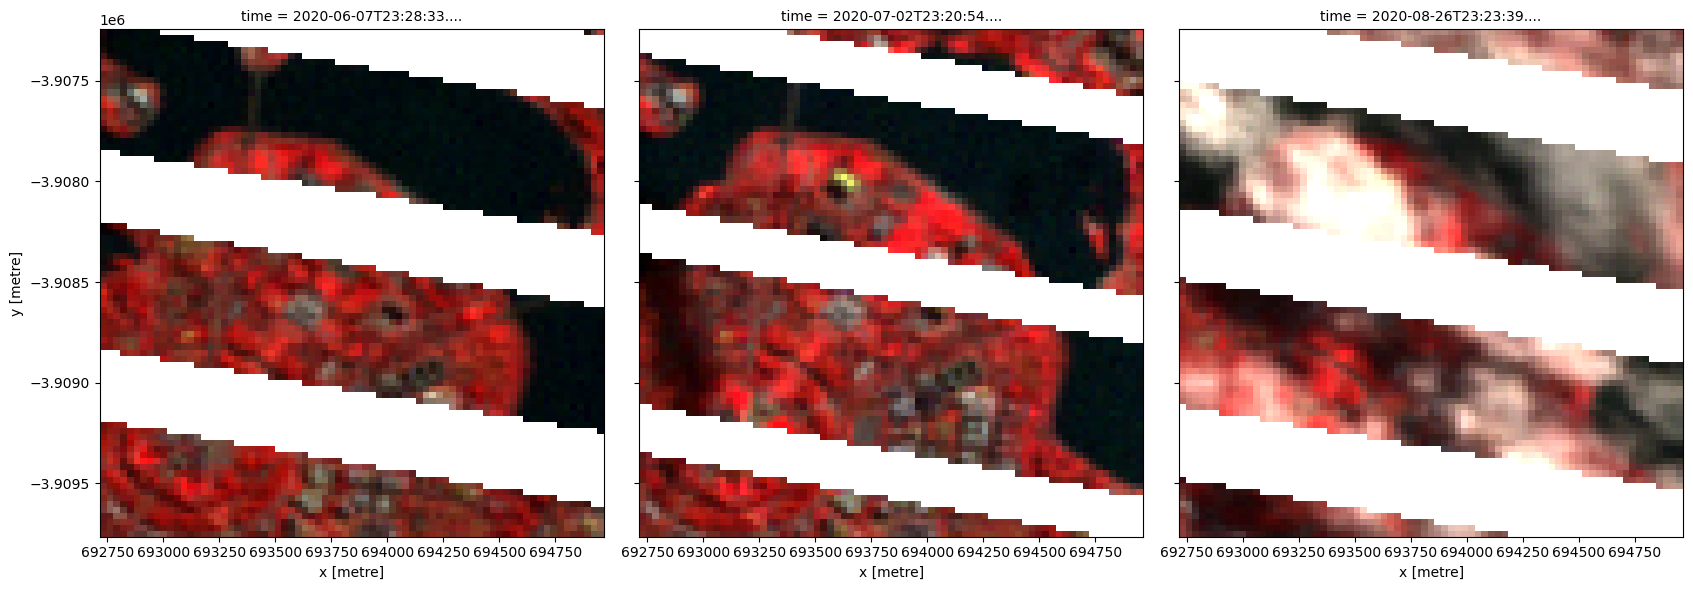

In [92]:
# Load NIR, red, green and panchromatic band data at 15 m resolution
nrgp_15m = load_ard(dc=dc,
    products=["ga_ls7e_ard_3"],
    measurements=["nbart_nir", "nbart_red", "nbart_green", "nbart_panchromatic"],
    resolution=(-15, 15),
    align=(7.5, 7.5),
    output_crs=output_crs,
    resampling="bilinear",
    group_by="solar_day",
    mask_pixel_quality=False,
    mask_contiguity=True,
    **query
)

# For reference, load the same image at 30 m resolution
nrg_30m = load_ard(dc=dc,
    products=["ga_ls7e_ard_3"],
    measurements=["nbart_nir", "nbart_red", "nbart_green"],
    resolution=(-30, 30),
    align=(15, 15),
    output_crs=output_crs,
    group_by="solar_day",
    mask_pixel_quality=False,
    mask_contiguity=True,
    **query
)

# Plot our original 30 m false colour images
rgb(nrg_30m, bands=["nbart_nir", "nbart_red", "nbart_green"], col="time")

We can now apply pansharpening to produce a higher resolution pansharpened false colour dataset:

Applying PCA pansharpening to each timestep


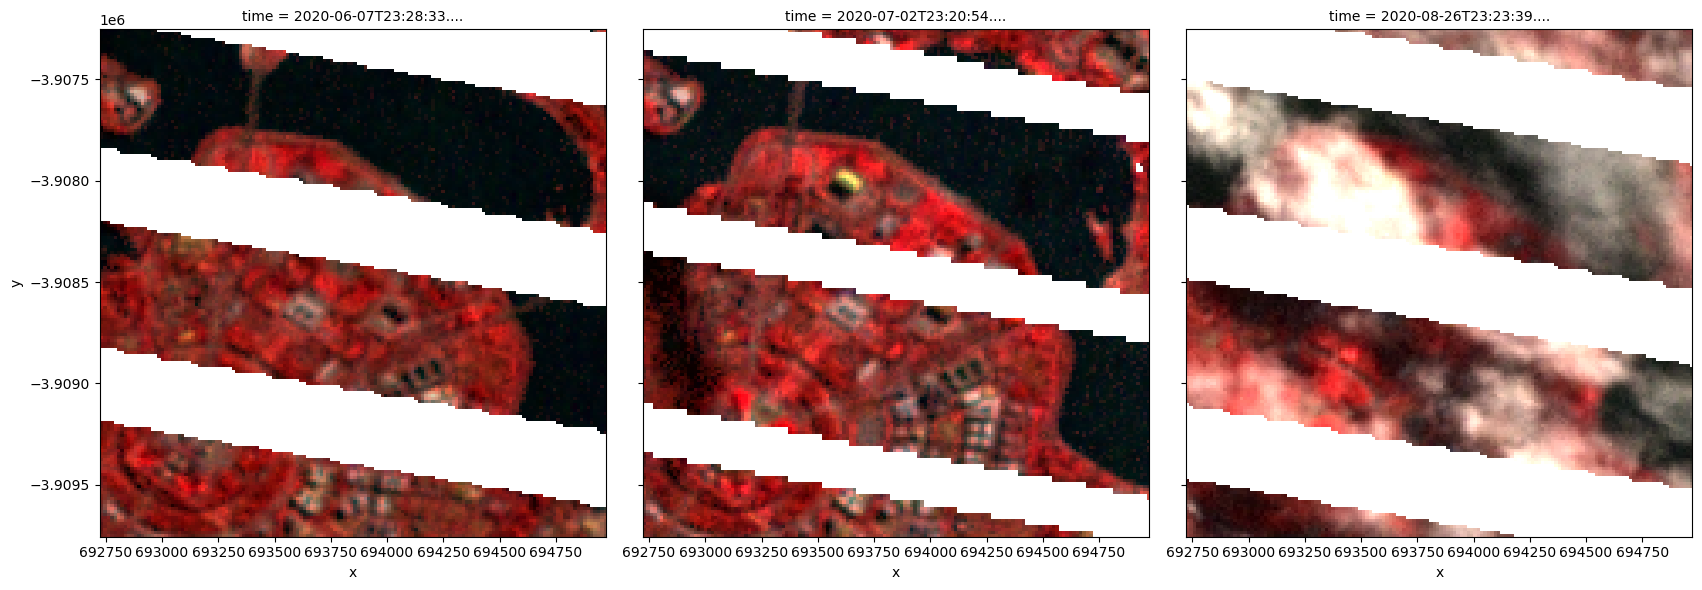

In [91]:
# Perform PCA pansharpening on NIR, Red and Green band data
nrg_pca_15m = xr_pansharpen(nrgp_15m, transform="pca")

# Plot our pansharpened 15 m false colour images
rgb(nrg_pca_15m, bands=["nbart_nir", "nbart_red", "nbart_green"], col="time")

## Advanced

### Evaluating pansharpening method performance

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2023

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)